In [ ]:
#!conda create -n env_pytorch python=3.6 -y
#!source activate env_pytorch

In [ ]:
pip install torch --user

In [2]:
#!pip install u8darts[all]
#!pip install u8darts[torch]
#!pip install torch#
#!pip install tensorflow==2.10 --ignore-installed

In [3]:
#conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
#!pip install keras

In [4]:
from keras.models import load_model

#Frugally Deep
#!git clone https://github.com/Dobiasd/frugally-deep

#model.save('LSTM-TMobile-UMTS.h5')  # creates a HDF5 file 'my_model.h5'
#model.save('LSTM-TMobile-LTE.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

#!python3 frugally_deep/keras_export/convert_model.py LSTM.h5 fdeep_model_TMobile_UMTS.json

2023-04-07 20:10:29.081930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 20:10:29.240723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 20:10:29.240761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 20:10:29.272118: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-07 20:10:30.172324: W tensorflow/stream_executor/platform/de

In [5]:


#imports

import numpy as np


#!pip install pmdarima
#import pmdarima as pm


from data_analyzer import *
from support import *
from prediction_error_evaluator import *

from change_reg_support import *
from historic_model import *

from trace_file_processor import *

import matplotlib.pyplot as plt

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout


In [6]:


#Loading and processing relevant data
data = get_all_trial_datasets()
processed_train_data = get_all_trial_processed_datasets(data)

### CONSTANTS ###

DIM = 5
DROP_FROM = 6

#Using this will mean that the new_processed data will have labels and data points overlap at time t. We need
#this since we will do our own pre-processing before fitting the LSTM
STEP = 'STEP_0'

new_processed = process_labels_and_dataset(processed_train_data, int(STEP[-1:]))



In [7]:
WINDOW = 1


In [8]:
trace = 'ATT-LTE'

true_link_capacity = processed_train_data[trace][LABELS][:]  #Dropping first few data points to to outlier drop

X = new_processed[trace][PROCESSED_DATASETS][AVERAGE][:,:] #Dropping first few data points to outlier drop

y = new_processed[trace][LABELS][:] #The labels are now the change in throughput between time steps
X_new = X[:,1:] #Dropping the pure throughput feature as we do not want to condition on it

In [9]:

# Important constants

#We need to drop the same number of datapoints not used in linear historic for normal linear regression.
#This is because otherwise there is some slight discrepancy in the results
steps = 10


# Model Name Constants

_LINEAR = 'LINEAR'
_LIN_HISTORIC = 'LIN_HISTORIC'
_SIMPLE_RNN = 'SIMPLE_RNN'
_LSTM = 'LSTM'
_GRU = 'GRU'
_CONV1D = 'CONV1D'
_ARIMA = 'ARIMA'
_POLY = 'POLY'
_EWMA = 'EWMA'
_TRANS = 'TRANSFORMER'
_CURRENT = 'CURRENT'
_SPROUT_STOCH = 'STOCH'


def evaluate(true, pred):

    RMSE = np.sqrt(mean_squared_error(true, pred))
    
    #MAE = np.mean(np.abs(true - pred))
    
    
    factor = 1 #SMAPE has this formally speaking as 2 but in practice it is fine to exclude it to get bound 0%-100%
    
    #SMAPE = np.mean( np.abs(pred - true) / 
    #        ((np.abs(pred) + np.abs(true))/factor) )*100
    
    #MAPE =  np.mean(np.abs((true - pred)/true)) #Issue is this throws errors as we are predicting small values close to 0
    
    return RMSE, 0

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        
        if (i + target_size > end_index): break
        
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])


    return np.array(data), np.array(labels)
    
    
def split_data_into_train_val(X, y, algo='LSTM'):
    
    train_size_index = int(np.ceil(0.7*len(X))) #70% for training

    train = X[:train_size_index]
    val = X[train_size_index:]
    
    #Only relevant for CONV1D and ARIMA
    X_train = train
    y_train = y[:train_size_index]
    X_val = val
    y_val = y[train_size_index:]
    
    if (algo != 'CONV1D'):

        # split into input and outputs
        X_train, y_train = train[:, :-1], train[:, -1]
        X_val, y_val = val[:, :-1], val[:, -1]

    return X_train, y_train, X_val, y_val
    
def train_arbitrary_model(train, window, future, show=False, trace=''):
    
    models = {}
    
    loop_data = traces
    
    if trace != '':
        
        loop_data = [trace] 
        
    
    #print(loop_data)
    for tr in loop_data:
        
        true_link_capacity = processed_train_data[tr][LABELS][DROP_FROM:]  #Dropping first few data points to to outlier drop

        X = new_processed[tr][PROCESSED_DATASETS][AVERAGE][DROP_FROM:,:] #Dropping first few data points to outlier drop
        
        #if trace=='TMobile-LTE':print(true_link_capacity)

        y = new_processed[tr][LABELS][DROP_FROM:] #The labels are now the change in throughput between time steps
        #X_new = X[:,1:] #Dropping the pure throughput feature as we do not want to condition on it
        
        
        data = np.hstack((y[:,None], X))
        
        model, name = train(data, true_link_capacity, tr, window, future, show)
        
        models[tr] = model
    
    return models, name
    

#Will take an arbitrary number of training functions as argument
def compute_all_results(show, *argv):
    
    # Will hold mapping between model type and corresponding results for each trace
    results = {}
    
    wind = argv[len(argv) - 2]
    fut = argv[len(argv) - 1]
    
    for i in range(0, len(argv) - 2):
        
        func = argv[i]
        
        models, name = train_arbitrary_model(func, wind, fut, show)
        
        results[name] = models
    
    return results

def plot_results_trace(results, trace):
    
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    
    for elem in results.keys():
        
        result = results[elem][trace][1]
        
        axs.scatter([elem], [result], label='')
    

    

def plot_results(results):
    
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    
    model_names = results.keys()
    
    for elem in model_names:
        
        result = []
        
        for trace in traces:
        
            result.append(results[elem][trace][1]) #Evaluation metric at this index
                            
        axs.scatter(traces, result, marker='x', label=elem)
    
    axs.set_title('Model RMSE vs Trace', pad=20, fontsize=14)
    axs.set_xlabel('Trace', fontsize=12)
    axs.set_ylabel('RMSE', fontsize=12)
    axs.grid()
    
    pos = axs.get_position()
    axs.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    axs.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
   
    
    fig.savefig('RMSE-vs-Model.png', dpi=1000)

    
"""
def plot_results(results):
    
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    
    model_names = results.keys()
    
    for trace in traces:
        
        result = []
        
        for elem in model_names:
        
            result.append(results[elem][trace][1]) #Evaluation metric at this index
                            
        axs.scatter(model_names, result, marker='x', label=trace)
    
    axs.set_title('MAE vs Forecast Model', pad=20, fontsize=14)
    axs.set_xlabel('Model', fontsize=12)
    axs.set_ylabel('MAE', fontsize=12)
    axs.grid()
    axs.legend()
"""
        
        
        
        
    

"\ndef plot_results(results):\n    \n    fig, axs = plt.subplots(1, 1, figsize=(7, 4))\n    \n    model_names = results.keys()\n    \n    for trace in traces:\n        \n        result = []\n        \n        for elem in model_names:\n        \n            result.append(results[elem][trace][1]) #Evaluation metric at this index\n                            \n        axs.scatter(model_names, result, marker='x', label=trace)\n    \n    axs.set_title('MAE vs Forecast Model', pad=20, fontsize=14)\n    axs.set_xlabel('Model', fontsize=12)\n    axs.set_ylabel('MAE', fontsize=12)\n    axs.grid()\n    axs.legend()\n"

In [10]:

### THIS BOX DEALS WITH SIMPLE LINEAR REGRESSION ###

def train_LIN(data, true_cap, trace, window, future, show=False):
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    X, y = multivariate_data(data[:,1:], data[:,0], 0, len(data), window, future, 1, single_step=False)
    
    
    X = X[steps-1:]
    y = y[steps-1:]
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(X, y, 'CONV1D')
    
    X_train = X_train[:,0,:] #to go from 3D to 2D
    
    #print(X_train.shape)
    #print(y_train[:,0].shape)
    #print(X_train[:,0,:].shape)

    models = []
    
    for i in range(0, future):
        
        #Fitting Simple Linear Regression
        
        w, b = fit_linreg_natural(X_train, y_train[:,i], 30)
    
        model = np.array([w, b], dtype=object)
        
        models.append(model)
    
    pred = X_val@models[0][0] + models[0][1]
    pred = pred[:,None][:,0,:]
    
    for j in range(1, len(models)):
        
        mod = models[j]
        
        fut_predict = X_val@mod[0] + mod[1]
        
        #print(pred.shape)
        #print(fut_predict.shape)
        
        pred = np.hstack((pred, fut_predict))
    
    
    #print(y_val.shape)
    #print(pred.shape)
    rmse, mape = evaluate(y_val, pred)
    
    return (models, rmse, mape), _LINEAR

In [ ]:
f, _ = train_arbitrary_model(train_LIN, 1, 4)

In [ ]:
FUTURE=4
g, _ = train_arbitrary_model(train_LIN, 1, 20)

In [ ]:
f

In [ ]:
g['TMobile-LTE'][0]

In [20]:


### THIS BOX DEALS WITH HISTORIC LINEAR REGRESSION ###

def train_LIN_HISTORIC(data, true_cap, trace, window, future, show=False):

    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    X, y = multivariate_data(data[:,1:], data[:,0], 0, len(data), window, future, 1, single_step=False)
    
    X = X[:,0,:] #to go from 3D to 2D
    
    X = np.hstack((np.repeat(1, len(X))[:,None], X)) #Add dummy data at first column for compatibility
    X_adj = get_dataset_for_cong_signal_history(X, steps)
    
    X_adj = X_adj[steps-1:] #Dropping points underneath as no historic data was available
    y = y[steps-1:]
    
    #y = y[:,0]
    #print(X_adj)
    
    timestep_models = []
    
    start = True
    
    predictions = []
    all_y_val = []
    
    for i in range(0, future):
        
        #Note: This takes care of splitting the data as appropriate as well
        models, opt, X_shuf_val, y_shuf_val, square_error_train, square_error_val = train_historic_model(X_adj, y[:,i], steps)
        opt=3
        predictor_best_val = models[opt - 1]
        
        pred = X_shuf_val[:,:3*opt]@predictor_best_val[0] + predictor_best_val[1]
        
        if (start):
            
            predictions = pred[:,None]
            all_y_val = y_shuf_val[:,None]
            start = False
        
        else:
            
            predictions = np.hstack((predictions, pred[:,None]))
            all_y_val = np.hstack((all_y_val,y_shuf_val[:,None]))
        
        rmse, mape = evaluate(y_shuf_val, pred)
        
        timestep_models.append((predictor_best_val, rmse, opt, mape))
    
    rmse_tot, mape_tot = evaluate(all_y_val, predictions)
            
    return (timestep_models, rmse_tot, mape_tot), _LIN_HISTORIC

In [21]:

f = train_arbitrary_model(train_LIN_HISTORIC, 1, 3, show=False)


In [22]:
f[0]['TMobile-UMTS']

([(array([array([ 1.38115905e-04, -9.39491044e-06, -3.53076788e-04,  2.09444906e-04,
                  1.11435065e-05, -1.21761322e-03, -9.42874165e-04,  3.87112269e-05,
                  1.48479716e-03])                                                  ,
          array(-0.00417372)], dtype=object),
   0.3167323892521348,
   3,
   0),
  (array([array([ 2.37968253e-04,  1.75247653e-05, -1.62492346e-03, -9.96440842e-04,
                  4.90448775e-05,  3.38010041e-04,  6.24496833e-04, -3.68413177e-05,
                  1.41929303e-03])                                                  ,
          array(-0.00613785)], dtype=object),
   0.3164721776339206,
   3,
   0),
  (array([array([-1.02331970e-03,  5.53887817e-05, -7.58774632e-04,  5.16792747e-04,
                 -2.92201535e-05,  2.39766418e-03,  1.04472089e-04, -2.79035606e-05,
                 -1.62597847e-03])                                                  ,
          array(-5.62194811e-05)], dtype=object),
   0.3167262806406

In [16]:
g = train_arbitrary_model(train_LIN_HISTORIC, 1, 3, show=False)


In [17]:
g[0]['TMobile-UMTS']

([(array([array([ 1.44025130e-04, -1.96054312e-06, -5.81905525e-04,  2.20559692e-04,
                  1.81567964e-05, -1.21580762e-03, -1.00578864e-03,  4.87104739e-05,
                  3.25654219e-04,  6.01901216e-04, -3.74814686e-05,  1.52247025e-03]),
          array(-0.00408083)], dtype=object),
   0.3165666207732234,
   4,
   0),
  (array([array([ 2.37968253e-04,  1.75247653e-05, -1.62492346e-03, -9.96440842e-04,
                  4.90448775e-05,  3.38010041e-04,  6.24496833e-04, -3.68413177e-05,
                  1.41929303e-03])                                                  ,
          array(-0.00613785)], dtype=object),
   0.3164721776339206,
   3,
   0),
  (array([array([-9.49864808e-04,  5.57582450e-05, -8.35888236e-04,  6.58396321e-04,
                 -3.22618060e-05,  1.25523077e-03])                                 ,
          array(-0.0115263)], dtype=object),
   0.31659619746019796,
   2,
   0)],
 0.31654500304084743,
 0)

In [12]:


### THIS BOX SIMULATES SPROUT-EWMA ###

def get_change_rmse(X, y):
    
    square_error = []

    for i in range(0, len(y) - 1):
    
        current = X[i]
    
        next_timestep = y[i]
    
        error = (next_timestep - current)**2
    
        square_error.append(error)

    rmse = np.sqrt(np.mean(square_error))
    
    return rmse

def train_EWMA(data, true_cap, trace, window, future, show=False):
    
    alpha=1/4
    
    true_link_capacity = true_cap
    
    #Only care about the throughput value for sprout-ma
    #X = data[:,1]
    
    X, y = multivariate_data(data[:,1:], true_link_capacity[:len(true_link_capacity) - 1], 0, len(data), window, future, 1, single_step=False)
    
    X = X[:,0,0] #goes from 3D to 2D at the same time
    
    #print(X.shape)
    
    # To calculate RMSE of a sprout-MA then note that it operates by assuming that there will be NO change in throughput
    # (in other words it continues at the same rate) based on the current measured one.
    # 
    # Hence, we are looking for how many entries were "zero" in the change. We are interested in how well an average
    # can actually predict the future change

    # In other words if the values at the corresponding time steps in the X and y array match then that is correct otherwise
    # we incur a penalty equivalent to the difference.

    # However, since we dropped an element from X in the process function, need to drop an element from the true_link_capacity
    # array to ensure we start at correct times.
    
    X_ewma = []

    # Create the ewma sequence based on the current data
    # Note: if alpha set to 1 then will simply be a moving average
    for i in range(0, len(X)):
    
        if (i == 0):
        
            X_ewma.append(X[i])
    
        else:
        
            value = (1-alpha)*X_ewma[i - 1] + alpha*X[i]
            X_ewma.append(value)

    X_ewma = np.array(X_ewma)
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(X_ewma, y, 'CONV1D')
    
    predictions = []
    all_y_val = []
    start = True
    
    for i in range(0, future):
        
        rmse = get_change_rmse(X_val[:,None], y_val[:,i])
        #tot_rmse.append(rmse)
        
        if (start):
            
            predictions = X_val[:,None]
            all_y_val = y_val[:,i][:,None]
            start = False
        
        else:
            
            predictions = np.hstack((predictions, X_val[:,None]))
            all_y_val = np.hstack((all_y_val, y_val[:,i][:,None]))
        
    #rmse, mape = evaluate(y_val[:len(y_val)-1], X_val)
    rmse, mape = evaluate(all_y_val, predictions)
    
    #rmse, mape = evaluate(y_val[:len(y_val)-1], X_val)
    
    #print(rmse)
    
    return (X_ewma, rmse), _EWMA



In [13]:
def train_CURRENT(data, true_cap, trace, window, future, show=False):
    
    alpha=1/4
    
    true_link_capacity = true_cap
    #true_link_capacity = processed_train_data[trace][LABELS][DROP_FROM:]  #Dropping first few data points to to outlier drop

    #X = new_processed[trace][PROCESSED_DATASETS][50][DROP_FROM:,:] #Dropping first few data points to outlier drop

    #print(X == data[:,1:])
        
    #We have not deleted throughput column at index 1 from X in this function
    
    # To calculate RMSE of a sprout-MA then note that it operates by assuming that there will be NO change in throughput
    # (in other words it continues at the same rate) based on the current measured one.
    # 
    # Hence, we are looking for how many entries were "zero" in the change. We are interested in how well an average
    # can actually predict the future change

    # In other words if the values at the corresponding time steps in the X and y array match then that is correct otherwise
    # we incur a penalty equivalent to the difference.

    # However, since we dropped an element from X in the process function, need to drop an element from the true_link_capacity
    # array to ensure we start at correct times.
    
    X, y = multivariate_data(data[:,1:], true_link_capacity[:len(true_link_capacity) - 1], 0, len(data), window, future, 1, single_step=False)
    
    #Only care about the throughput value for sprout-ma
    X = X[:,0,0] #goes from 3D to 2D at the same time
    #print(X[20:25])
    #X = X[:,0,:] #to go from 3D to 2D
    
    #print(X.shape)
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(X, y, 'CONV1D')
    
    predictions = []
    all_y_val = []
    start = True
    
    for i in range(0, future):
        
        rmse = get_change_rmse(X_val[:,None], y_val[:,i])
        #tot_rmse.append(rmse)
        
        if (start):
            
            predictions = X_val[:,None]
            all_y_val = y_val[:,i][:,None]
            start = False
        
        else:
            
            
            predictions = np.hstack((predictions, X_val[:,None]))
            all_y_val = np.hstack((all_y_val, y_val[:,i][:,None]))
        
    #rmse, mape = evaluate(y_val[:len(y_val)-1], X_val)
    rmse, mape = evaluate(all_y_val, predictions)
    
    #print(rmse)
    
    return (X, rmse), _CURRENT

In [ ]:
train_arbitrary_model(train_EWMA, 1, 1)

In [14]:

def train_SPROUT(data, true_cap, trace, window, future, show=False):
    
    #print(true_cap)
    
    data = []
    
    with open('Sprout-RMSE/sprout-throughput-' + trace + '.csv') as file:
        
        lines = file.readlines()
    
    
    #NOTE: data will be trimmed by 3.07s due to delay in start. We are already trimming the true link capacity
    #      data array in data_analyzer so both start at same time. Just need to ensure that they are same length
    #          -> drop last elements of longer one
    for line in lines:
        
        to_mbits_per_sec = float(line) * 1400 * 8 / (20*1000)
        data.append(to_mbits_per_sec)
    
    
    #print(len(data))
    
    g = process_target_trace('traces/' + trace + '-driving.up', DELAY_FACTOR, 20, data)
    
    #print(len(g))
    
    data = data[1:] #drop first element since process_target_trace will generate corresponding truth at t+1
    g = g[:len(g) - 1] #Drop last element since we are just interested in the overlap as that is what sprout-stochastic predicted
    
    data = data[DROP_FROM:]
    g = g[DROP_FROM:]
    
    #print(data[0:7])
    
    #print(g[:7])
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(data, g, 'CONV1D')
    
    #Check correspondance
    rmse, _ = evaluate(X_val, y_val) #args: true, pred
    
    #print(rmse)
    
    return (data, rmse), _SPROUT_STOCH
        


In [ ]:
f = train_arbitrary_model(train_SPROUT, 1, 1, trace='Verizon-LTE')

In [ ]:
d, b = train_SPROUT([], true_link_capacity, 'Verizon-LTE', show=False)
#d[:][:10] #drop first element since process_target_trace will generate corresponding truth at t+1

In [ ]:
#Note: Need true link_capacity for 20ms since data for vanilla Sprout was collected based on 20ms

g = process_target_trace('traces/ATT-LTE-driving.up', DELAY_FACTOR, 20,d)

In [ ]:
g[:len(g) - 1] #Drop last element since we are just interested in the overlap as that is what sprout-stochastic predicted

In [ ]:
#f = train_arbitrary_model(train_SPROUT)

f[0]['Verizon-LTE'][1]

In [15]:

### THIS BOX DEALS WITH SIMPLE RNN and LSTM ###


# Creates a simple RNN for us - mainly to compare with LSTM later on
def create_SimpleRNN(hidden_units, dense_units, input_shape, activation):
    
    ### Designing RNN network ###
    
    model = Sequential()
    
    #One layer
    #Note: Default activation is tanh
    model.add(SimpleRNN(units=10, return_sequences=True, input_shape=input_shape, activation='relu'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

    #In LSTM, GRU, and TCN layers, the return_sequence 
    #in last layer before Dence Layer must set False . It is one of conditions that you encounter to this error message
    model.add(SimpleRNN(units=10, return_sequences=False, input_shape=input_shape, activation='linear'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.
    
    model.add(Dense(units=dense_units, activation='linear'))
    #model.add(Dense(units=1, activation='linear'))
    
    #Using mse since they do not have rmse
    model.compile(loss='mse', optimizer='adam')

    return model

def create_LSTM(hidden_units, dense_units, input_shape, activation):
    
    ### Designing the LSTM network ###

    model = Sequential()
    
    #One layer
    #Note: Default activation is tanh
    model.add(LSTM(units=10, return_sequences=True, input_shape=input_shape, activation='relu'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

    #In LSTM, GRU, and TCN layers, the return_sequence 
    #in last layer before Dence Layer must set False . It is one of conditions that you encounter to this error message
    model.add(LSTM(units=10, return_sequences=False, input_shape=input_shape, activation='linear'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.
    
    model.add(Dense(units=dense_units, activation='linear'))
    #model.add(Dense(units=1, activation='linear'))
    
    #Using mse since they do not have rmse
    model.compile(loss='mse', optimizer='adam')
    
    #model = Sequential()
    #model.add(LSTM(128, return_sequences=False, input_shape=input_shape))
    #model.add(Dense(1))
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

#Note: GRUs are simplified versions of LSTM that usually obtain the same
#      performance/accuracy on smaller datasets
#      They are also much more computationally efficient

def create_GRU(h_units, d_units, input_shape, activation):
    
    model = Sequential()
    
    #One layer
    #Note: Default activation is tanh
    model.add(GRU(units=10, return_sequences=True, input_shape=input_shape, activation='relu'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

    #In LSTM, GRU, and TCN layers, the return_sequence 
    #in last layer before Dence Layer must set False . It is one of conditions that you encounter to this error message
    model.add(GRU(units=10, return_sequences=False, input_shape=input_shape, activation='linear'))
    
    model.add(Dropout(0.2)) # 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.
    
    model.add(Dense(units=d_units, activation='linear'))
    #model.add(Dense(units=1, activation='linear'))
    
    #Using mse since they do not have rmse
    model.compile(loss='mse', optimizer='adam')
    
    #model = Sequential()
    #model.add(GRU(128, return_sequences=False, input_shape=input_shape))
    #model.add(Dense(1))
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model



In [16]:

FUTURE = 2


In [17]:

def train_RNN(data, hidden_units, dense_units, activation, window, show=False, mode='LSTM'):
    
    # NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    #data will have labels in column 0, but we want it at column end
    X = np.hstack((data[:,1:], data[:,0][:,None]))
    

    # drop columns we don't want to predict - will drop all d(t) columns for rest of the features so we only get variable we are interested in
    #reframed.drop(reframed.columns[[0, 5, 6, 7]], axis=1, inplace=True)

    #X = reframed.values
    
    reframed, y = process_conv_data(X, window)
    
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(reframed, y, 'CONV1D')
    
    #IMPORTANT: You always have to give a three-dimensional array as an input to your LSTM network. 
    #           Where the first dimension represents the batch size, the second dimension represents 
    #           the number of time-steps you are feeding a sequence. And the third dimension represents the number of units in one input sequence. 
    #           For example, input shape looks like (batch_size, time_steps, seq_len)

    # FORMAT IS: (# of groups, time steps in each group, # of columns or types of variables).
    #     -> in other words, the time steps in each group would be our 'historic' length

    # reshape input to be 3D [samples, timesteps, features]
    #X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    #X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    
    input_shape = input_shape=(X_train.shape[1], X_train.shape[2])
    ### Designing the LSTM network ###
    
    if mode == 'LSTM':
        
        model = create_LSTM(hidden_units, dense_units, input_shape, activation)

    elif mode == 'SIMPLE_RNN':
        
        model = create_SimpleRNN(hidden_units, dense_units, input_shape, activation)
    
    elif mode == 'GRU':
        
        model = create_GRU(hidden_units, dense_units, input_shape, activation)
    
    ### Fitting  ###

    # IMPORTANT: The reason for passing in the validation data at this stage is because as the model is trained
    #            it will also predict the result on the validation data (note: it will not train on it at all).
    #            This is so I can verify that the model is generalizing to a decent extent and that it has not overfitted.

    fitting_process = model.fit(X_train, y_train, epochs=120, batch_size=500, validation_data=(X_val, y_val), verbose=0, shuffle=False)

    # plot history
    if (show):
        plt.plot(fitting_process.history['loss'], label='train')
        plt.plot(fitting_process.history['val_loss'], label='val')
        plt.legend()
        plt.show()

    # Evaluating
    yhat = model.predict(X_val)
    
    rmse, mape = evaluate(y_val, yhat)
    
    #print('Test RMSE: %.3f' % rmse)

    return (model, rmse, mape), mode


# Note: These functions below are just for compatibility with train_arb_func

def train_SimpleRNN(data, true_cap, trace, window, future, show=False):
    
    h_units = 15
    d_units = future
    activ = ['tanh', 'tanh']
    mode = 'SIMPLE_RNN'
    #window=WINDOW
    #future=FUTURE
    
    return train_RNN_GRU(data, h_units, d_units, activ, window, future, show, mode=mode)
    #return train_RNN(data, h_units, d_units, activ, window, show, mode=mode)
    
    
def train_LSTM(data, true_cap, trace, window, future, show=False):
    
    h_units = 15
    d_units = future
    activ = ['tanh', 'tanh']
    mode = 'LSTM'
    #window=WINDOW
    #future=FUTURE
    
    return train_RNN_GRU(data, h_units, d_units, activ, window, future, show, mode=mode)
    #return train_RNN(data, h_units, d_units, activ, window, show, mode=mode)

def train_GRU(data, true_cap, trace, window, future, show=False):
    
    h_units = 15
    d_units = future
    activ = ['tanh', 'tanh']
    mode = 'GRU'
    #window=WINDOW
    #future=FUTURE
    
    #return train_RNN(data, h_units, d_units, activ, window, show, mode=mode)
    return train_RNN_GRU(data, h_units, d_units, activ, window, future, show, mode=mode)

In [18]:
#window = 1
#future = 3


#a, b = multivariate_data(X_new, y, 0, len(X_new), window, future, 1, single_step=False)


In [19]:
def train_RNN_GRU(data, hidden_units, dense_units, activation, window, future, show=False, mode='LSTM'):
    
    # NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    
    reframed, y = multivariate_data(data[:,1:], data[:,0], 0, len(data), window, future, 1, single_step=False)
    
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(reframed, y, 'CONV1D')
    
    #IMPORTANT: You always have to give a three-dimensional array as an input to your LSTM network. 
    #           Where the first dimension represents the batch size, the second dimension represents 
    #           the number of time-steps you are feeding a sequence. And the third dimension represents the number of units in one input sequence. 
    #           For example, input shape looks like (batch_size, time_steps, seq_len)

    # FORMAT IS: (# of groups, time steps in each group, # of columns or types of variables).
    #     -> in other words, the time steps in each group would be our 'historic' length

    # reshape input to be 3D [samples, timesteps, features]
    #X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    #X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    
    input_shape = input_shape=(X_train.shape[1], X_train.shape[2])
    ### Designing the LSTM network ###
    
    if mode == 'LSTM':
        
        model = create_LSTM(hidden_units, dense_units, input_shape, activation)

    elif mode == 'SIMPLE_RNN':
        
        model = create_SimpleRNN(hidden_units, dense_units, input_shape, activation)
    
    elif mode == 'GRU':
        
        model = create_GRU(hidden_units, dense_units, input_shape, activation)
    
    ### Fitting  ###

    # IMPORTANT: The reason for passing in the validation data at this stage is because as the model is trained
    #            it will also predict the result on the validation data (note: it will not train on it at all).
    #            This is so I can verify that the model is generalizing to a decent extent and that it has not overfitted.

    fitting_process = model.fit(X_train, y_train, epochs=120, batch_size=500, validation_data=(X_val, y_val), verbose=0, shuffle=False)

    # plot history
    if (show):
        plt.plot(fitting_process.history['loss'], label='train')
        plt.plot(fitting_process.history['val_loss'], label='val')
        plt.legend()
        plt.show()

    # Evaluating
    yhat = model.predict(X_val)
    
    print(yhat.shape)
    rmse, mape = evaluate(y_val, yhat)
    
    #print('Test RMSE: %.3f' % rmse)

    return (model, rmse, mape), mode

In [33]:
f = train_arbitrary_model(train_GRU, 1, 4)

47/47 [==============================] - 0s 1ms/step
(1495, 4)
47/47 [==============================] - 0s 1ms/step
(1495, 4)
47/47 [==============================] - 0s 1ms/step
(1494, 4)
47/47 [==============================] - 0s 2ms/step
(1495, 4)
47/47 [==============================] - 0s 1ms/step
(1495, 4)


In [30]:


m = f[0]['ATT-LTE'][0]

In [31]:
m.predict(np.array([[[1,2,3]]]))

1/1 [==============================] - 0s 233ms/step


array([[0.01980934, 0.04901438, 0.00403306, 0.02130499]], dtype=float32)

In [ ]:
#model.save('LSTM-ATT-LTE.h5')  # creates a HDF5 file 'my_model.h5'
#!python3 frugally_deep/keras_export/convert_model.py LSTM-ATT-LTE.h5 fdeep_model_ATT_LTE_LSTM.json

In [34]:
for elem in f[0].keys():
    
    model = f[0][elem][0]
    #print(model)
    model.save('GRU-4-{}.h5'.format(elem))  # creates a HDF5 file 'my_model.h5'
    #model.save('LSTM-TMobile-LTE.h5')  # creates a HDF5 file 'my_model.h5'
    #del model  # deletes the existing model

    # returns a compiled model
    # identical to the previous one
    #model = load_model('my_model.h5')


In [35]:
#!python3 frugally_deep/keras_export/convert_model.py GRU-ATT-LTE.h5 fdeep_model_ATT_LTE.json
#!python3 frugally_deep/keras_export/convert_model.py LSTM-TMobile-LTE.h5 fdeep_model_TMobile_LTE.json
#!python3 frugally_deep/keras_export/convert_model.py LSTM-TMobile-UMTS.h5 fdeep_model_TMobile_UMTS.json
!python3 frugally_deep/keras_export/convert_model.py GRU-4-TMobile-UMTS.h5 fdeep_model_GRU4_TMobile_UMTS.json
#!python3 frugally_deep/keras_export/convert_model.py GRU-Verizon-EVDO.h5 fdeep_model_Verizon_EVDO.json

2023-04-07 16:40:42.380443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 16:40:42.413262: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-07 16:40:43.165676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-07 16:40:43.165791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-07 16:40:43.165812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [ ]:
m, n =  process_conv_data(np.hstack((X_new, y[:,None])), 1)

In [ ]:
m

In [20]:

### THIS BOX DEALS WITH CONVULATIONAL NEURAL NETWORK ###

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a multivariate sequence into samples
def process_conv_data(data, step):
    
    X, y = list(), list()
    
    size = len(data)
    
    for i in range(size):
        
        end_ix = i + step
        
        if (end_ix > size):
            break
        
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix-1, -1]
        
        X.append(seq_x)
        y.append(seq_y)
            
    return np.array(X), np.array(y)
 

#

def create_CONV1D(filters, kernel_size, pool_size, activation, input_shape):
    
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    #model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
              
    return model

              
def train_CONV(data, filters, kernel_size, pool_size, activation, length, show=False):
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    #data will have labels in column 0, but we want it at column end
    X = np.hstack((data[:,1:], data[:,0][:,None]))
              
    # NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..
    X, y = process_conv_data(X, length)
    
    #print(X.shape)
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(X, y, algo='CONV1D')
    
    #X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    #X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    
    # Shape will be define by window length and features
    input_shape = input_shape=(length, X_train.shape[2])
              
    ### Designing the CONV network ###
    
    model = create_CONV1D(filters, kernel_size, pool_size, activation, input_shape)
    
    ### Fitting  ###

    # IMPORTANT: The reason for passing in the validation data at this stage is because as the model is trained
    #            it will also predict the result on the validation data (note: it will not train on it at all).
    #            This is so I can verify that the model is generalizing to a decent extent and that it has not overfitted.

    fitting_process = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_val, y_val), verbose=0, shuffle=False)

    # plot history
    if (show):
        plt.plot(fitting_process.history['loss'], label='train')
        plt.plot(fitting_process.history['val_loss'], label='val')
        plt.legend()
        plt.show()

    # Evaluating
    yhat = model.predict(X_val)
    
    rmse, mape = evaluate(y_val, yhat)
    
    #print('Test RMSE: %.3f' % rmse)

    return (model, rmse, mape), _CONV1D


              
def train_CONV1D(data, true_cap, show=False):
              
    filters = 64
    kernel_size = 2
    pool_size = 2
    activation = ['tanh', 'tanh']
    length = 3
              
    return train_CONV(data, filters, kernel_size, pool_size, activation, length, show=show)

In [21]:
#models = train_arbitrary_model(train_CONV1D, show=False)

#data = np.hstack((X_new, y[:,None]))

    # NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..
#X, lab = process_conv_data(X, 3)
    
#print(X.shape)
    
#X_train, y_train, X_val, y_val = split_data_into_train_val(X, lab, 'CONV1D')
#X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

In [22]:

### THIS IS FOR ARIMA AND ARMA MODELS ###



def train_ARIMA(data, true_cap, trace, show=False):
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(data[:,1:], data[:,0], 'CONV1D')
    
    #should do a tuning
    model = pm.auto_arima(y_train, X=X_train, m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    val = model.predict(len(X_val), X=X_val)
    
    # plot history
    if (show):
        
        train = model.predict_in_sample(X_train)
        #val = model.predict(len(X_val), X=X_val)
        axs[0].plot(train, label='train')
        axs[0].plot([x for x in np.arange(len(X_train), len(X_train) + len(X_val))], val, label='val')
        axs[1].plot([x for x in np.arange(len(data))], data[:,0], label='True', color='green')
        axs[0].legend()
        axs[1].legend()
        
    rmse, mape = evaluate(y_val, val)
    
    # Serialize with Pickle
    #with open(trace + '-ARIMA.pkl', 'wb') as pkl:
    #    pickle.dump(model, pkl)
        
    return (model, rmse, mape), _ARIMA



In [ ]:

data = np.hstack((y[:,None], X))

f, _ = train_ARIMA(data[:100], [], '', show=False)


In [ ]:
#model = f[0]

#model.predict(4, X=data[0:1][:,2:])

#data[0:1][:,2:]

In [23]:

### THIS BOX IS FOR POLYNOMIAL BASIS FUNCTIONS ###



#Polynomial basis function

def phi_poly(Xin, order):

    #Note this function does not add bias as our
    #fit_linreg procedure already does that
    
    X = Xin
    
    #We will only be adding order 2 or more
    for i in range(2, order + 1):
        
        Xin = np.hstack([Xin, X**i])
    
    return Xin


"""
We will consider polynomial orders up to 9
and choose the one that did the best on the
validation set.

Would usually adopt early stopping
but since we are just considering 9
models it is not necessary.

"""


#Note currently we are not using the transformed down dataset - Might want to change that

def get_models(X, y, orders):

    N = orders
    models_poly = []

    #Note: Start from 1 because of how phi_poly designed
    for i in range(1, N + 1):
    
        ww, bb = fit_linreg_natural(phi_poly(X, i), y, alpha=30)
    
        models_poly.append([ww, bb])
        
    return models_poly


def tune_models(Xsv, y_val, models_poly):

    #Examining which model does best on validation set

    best_model = models_poly[0]
    best_model_order = 1

    for i in range(1, len(models_poly)):
    
        w, b = models_poly[i][0], models_poly[i][1]
    
        w_best, b_best = best_model[0], best_model[1]
    
        X_val_transform_best = phi_poly(Xsv, best_model_order)
    
        #Note +1 as polynomial order 1 is at index 0
        X_val_transform = phi_poly(Xsv, i+1) 
    
        rmse_best = RMSE(X_val_transform_best, y_val, w_best, b_best)
        rmse_curr = RMSE(X_val_transform, y_val, w, b)

        if (rmse_best > rmse_curr):
        
            best_model = models_poly[i]
        
            #Note +1 as polynomial order 1 is at index 0
            best_model_order = i+1
    
    return best_model, best_model_order


def train_POLY(data, true_cap, trace, show=False):
    
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    X = data[:,1:][steps-1:]
    y = data[:,0][steps-1:]
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(X, y, 'CONV1D')
    
    models_poly = get_models(X_train, y_train, 100)
    
    best_model, best_model_order = tune_models(X_val, y_val, models_poly)
    
    X_transf = phi_poly(X_val, best_model_order)
        
    pred = X_transf@best_model[0] + best_model[1]
    
    rmse, mape = evaluate(y_val, pred)
    
    return (best_model, rmse, mape, best_model_order), _POLY

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping, Callback

In [25]:
class Time2Vec4TF(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vec4TF, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2

In [26]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class T2VTransformer(keras.Model):
    def __init__(
            self,
            num_hid=64, # embed_dim - num of features
            time_steps=7,
            window=1,
            num_head = 2,
            num_feed_forward=128, # pointwise dim
            num_layers_enc = 4,
            time_embedding = False,
    ):
        super().__init__()
        self.num_hid = num_hid
        if time_embedding:
            self.num_hid += 2
            self.tv = Time2Vec4TF(window)
        else:
            self.tv = None
        self.numlayers_enc = num_layers_enc
        self.enc_input = layers.Input((window, self.num_hid))
        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(self.num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        self.GlobalAveragePooling1D = layers.GlobalAveragePooling1D(data_format='channels_last')
        self.out = layers.Dense(units=time_steps, activation='linear')        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, inputs):
        if self.tv:
            x = self.tv(inputs)
            x = self.concat([inputs, x])
            x = self.encoder(x)
        else:
            x = self.encoder(inputs)
        x = self.GlobalAveragePooling1D(x)
        y = self.out(x)
        return y

In [27]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('.', end='')

In [28]:
def create_t2v_transformer(X_train_sequence, y_train_sequence):
    num_heads=2
    num_layers_enc=2
    num_feed_forward=64
    num_features = X_train_sequence.shape[2]
    time_steps = y_train_sequence.shape[1]
    window = X_train_sequence.shape[1]
    epochs = 100
    batch_size = 128

    model = T2VTransformer(num_hid=num_features,
                           time_steps=time_steps,
                           window = window,
                           time_embedding=True,
                           num_head=y_train_sequence.shape[1],
                           num_layers_enc=num_layers_enc,
                           num_feed_forward=num_feed_forward)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    
    return model
    


In [29]:

# NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..

def train_TRANS(data, true_cap, trace, window, future, show=False):
     
    data = np.delete(data, 1, 1) #column 1 has throughput - do not want to condition on it
    
    window = 1
    future = 1
    
    reframed, y = multivariate_data(data[:,1:], data[:,0], 0, len(data), window, future, 1, single_step=False)
    
    
    X_train, y_train, X_val, y_val = split_data_into_train_val(reframed, y, 'CONV1D')
    
    #print("X_train: {} y_train: {} X_val: {} y_val: {}".format(len(X_train), len(y_train), len(X_val), len(y_val)))

    print(X_train.shape)
    print(y_train.shape)
    
    model = create_t2v_transformer(X_train, y_train)
    
    monitor_label = 'val_loss'
    #early_stop = EarlyStopping(monitor=monitor_label, patience=50)
    history = model.fit(X_train, 
                    y_train,
                    epochs=120, 
                    batch_size = 500, 
                    validation_data = (X_val,
                                       y_val),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0)
    
    if (show):
        
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.legend()
        plt.show()
        
    yhat = model.predict(X_val)
    
    #print("yhat: {} y_val: {}".format(yhat, y_val))
    
    rmse, mape = evaluate(y_val, yhat)
        
    return (model, rmse, mape), _TRANS


In [ ]:
h = train_arbitrary_model(train_LSTM, 1, 4)

2023-04-06 09:01:25.777470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-06 09:01:25.777505: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-06 09:01:25.777539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noteable): /proc/driver/nvidia/version does not exist
2023-04-06 09:01:25.777791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


47/47 [==============================] - 0s 1ms/step
(1495, 1)
47/47 [==============================] - 0s 1ms/step
(1495, 2)
47/47 [==============================] - 0s 1ms/step
(1495, 3)
47/47 [==============================] - 0s 1ms/step
(1494, 4)
47/47 [==============================] - 0s 2ms/step
(1494, 5)
47/47 [==============================] - 0s 1ms/step
(1494, 6)
47/47 [==============================] - 0s 2ms/step
(1494, 7)
47/47 [==============================] - 0s 1ms/step
(1493, 8)
47/47 [==============================] - 0s 1ms/step
(1493, 9)
47/47 [==============================] - 0s 2ms/step
(1493, 10)
47/47 [==============================] - 0s 1ms/step
(1492, 11)
47/47 [==============================] - 0s 2ms/step
(1492, 12)
47/47 [==============================] - 0s 1ms/step
(1492, 13)
47/47 [==============================] - 0s 1ms/step
(1491, 14)
47/47 [==============================] - 0s 1ms/step
(1491, 15)
47/47 [==============================] - 0s 1ms/s

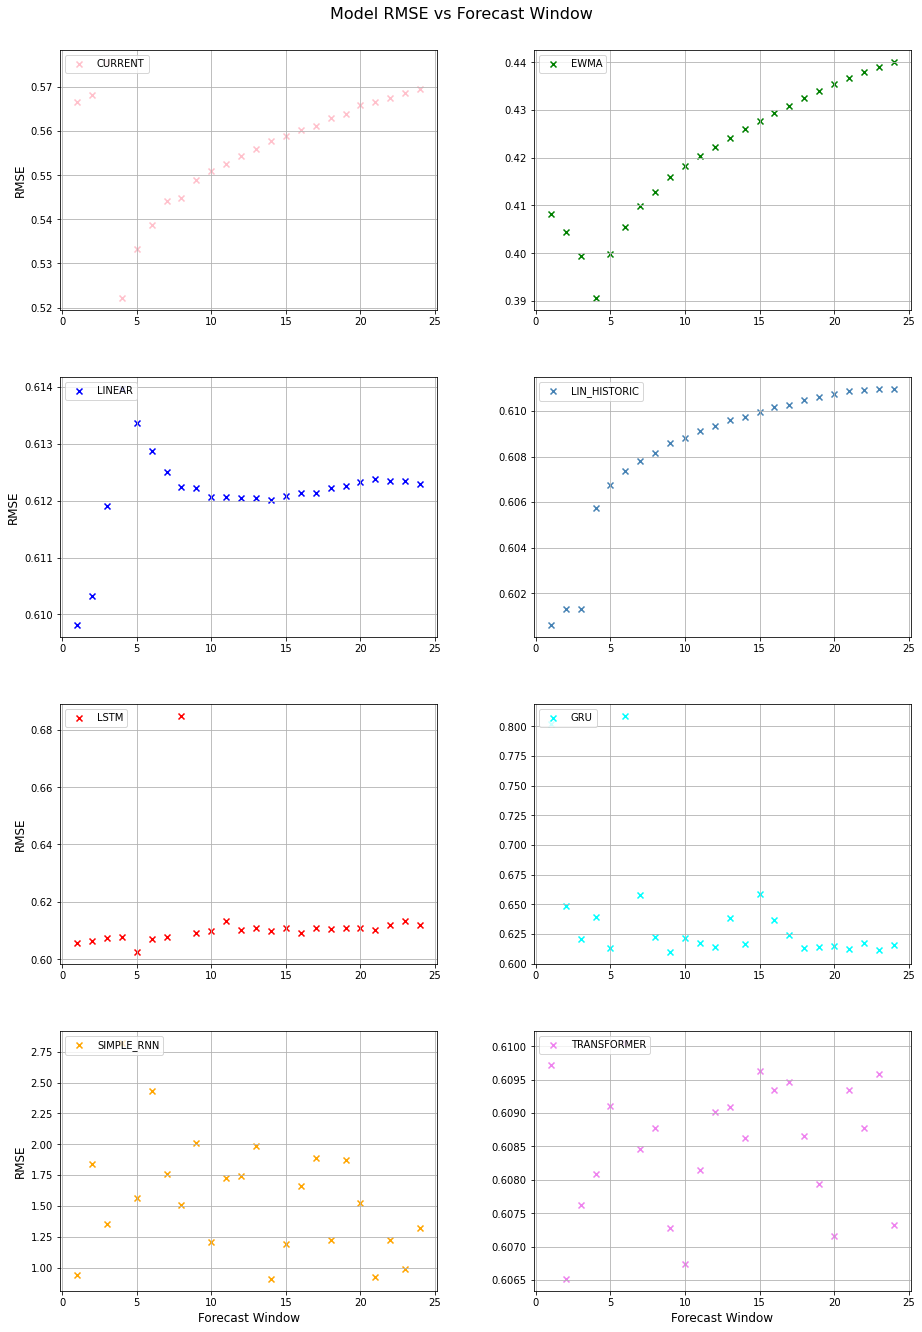

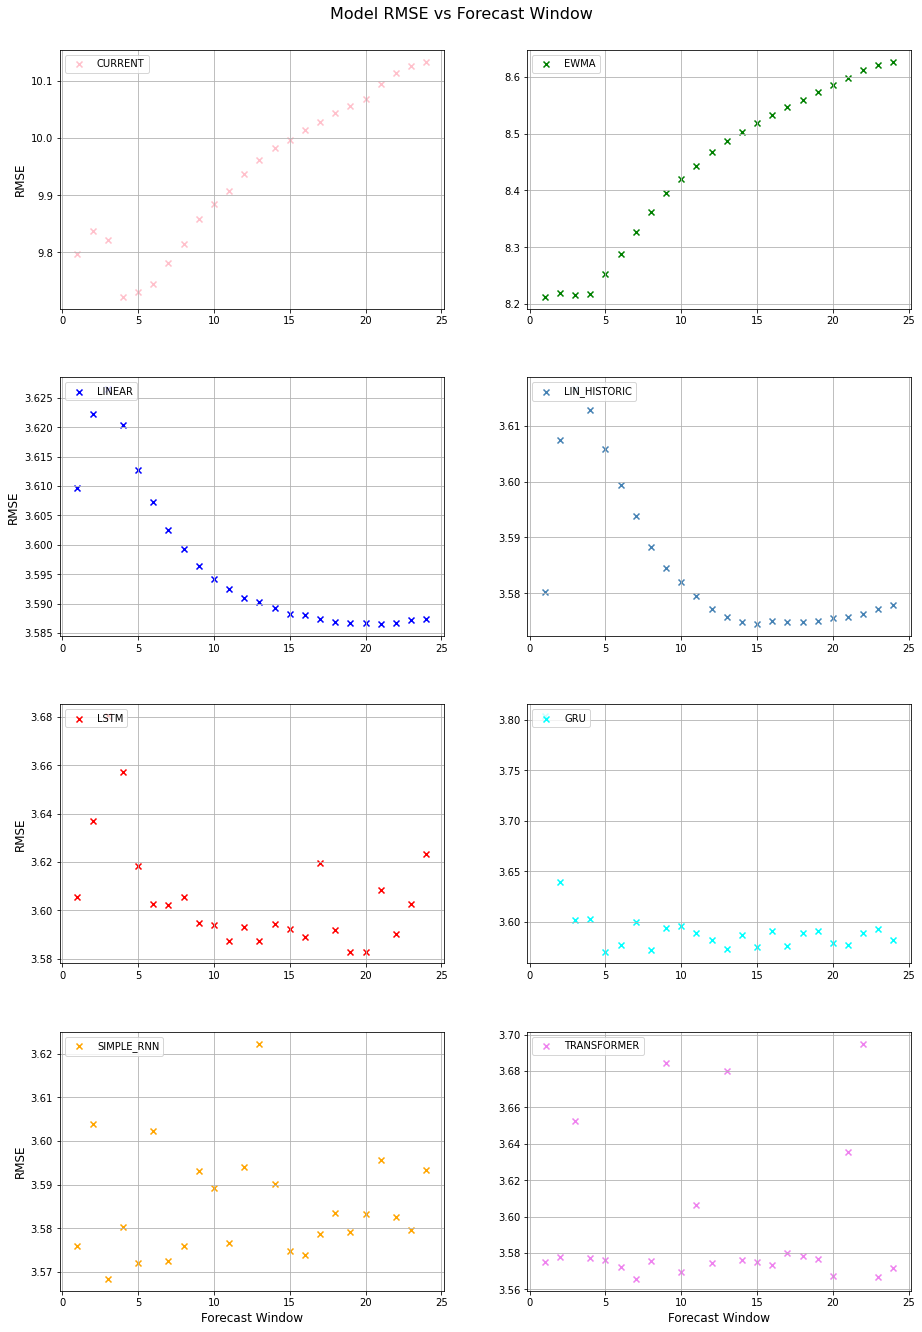

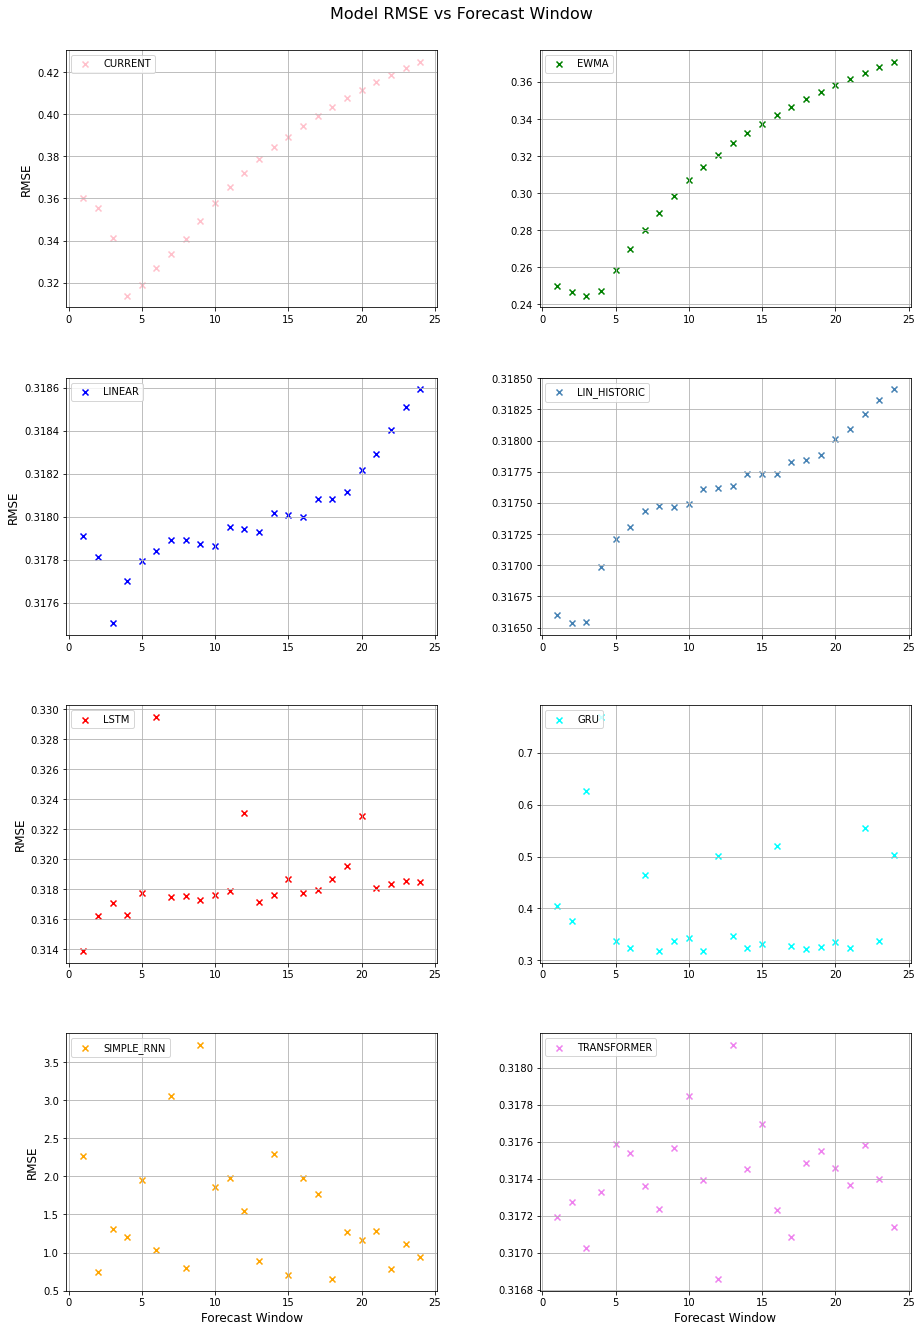

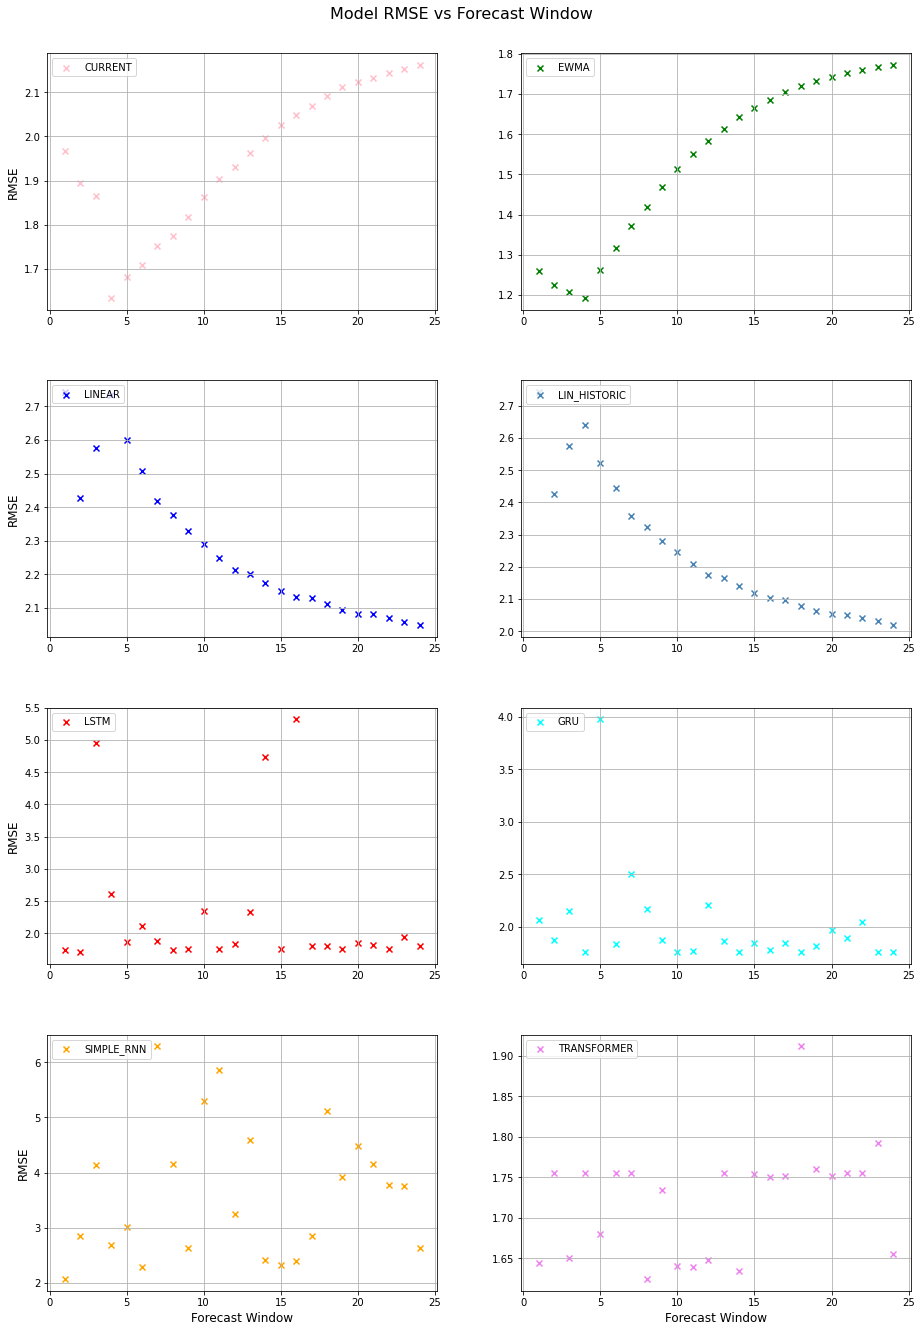

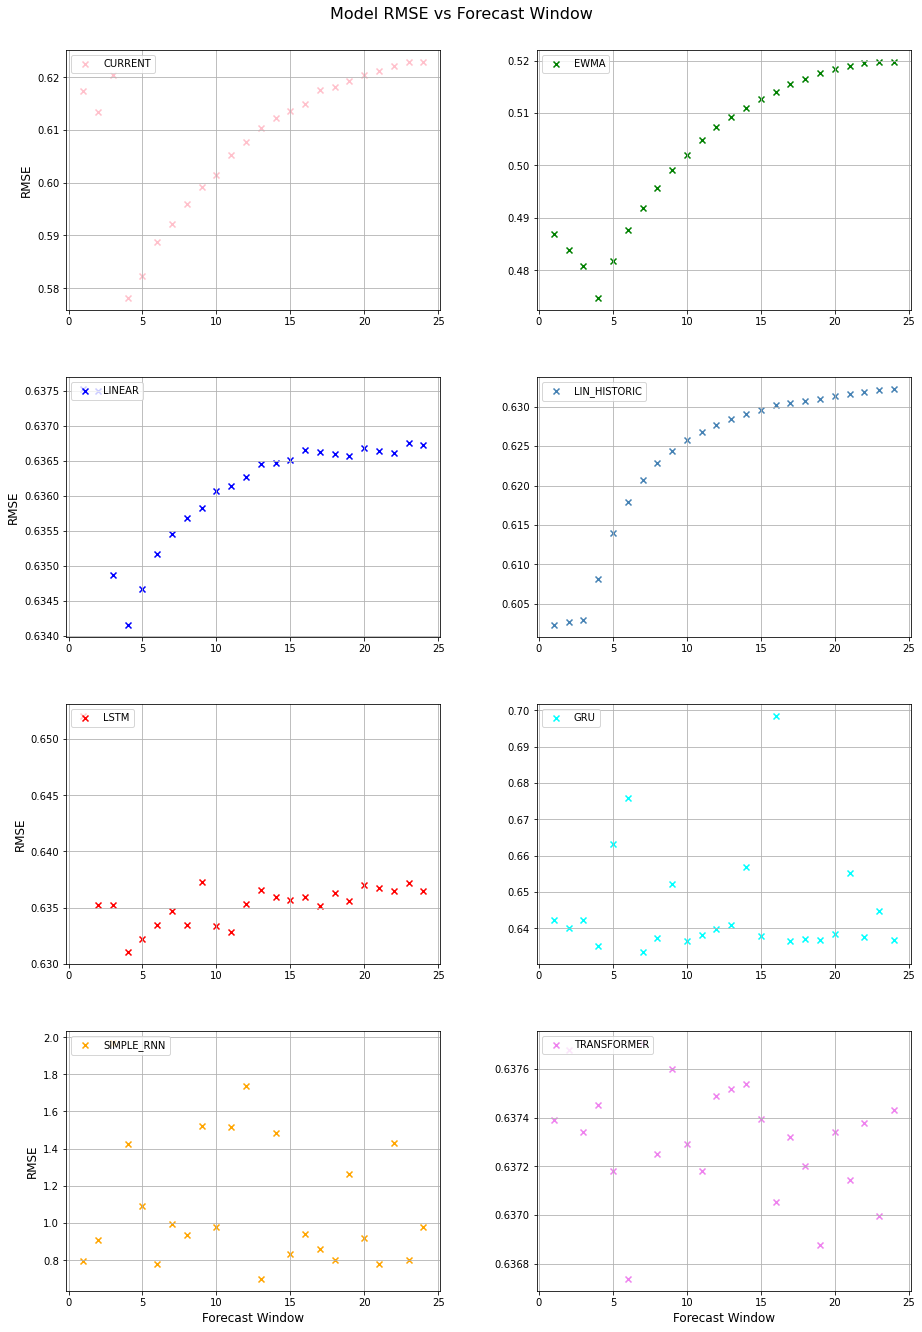

In [27]:


tra = ['ATT-LTE', 'TMobile-LTE', 'TMobile-UMTS', 'Verizon-LTE', 'Verizon-EVDO']
#tra = ['TMobile-UMTS']
for tr in tra:
    
    wind = 1
    fut = 1

    bound = 25

    path_to_files = 'Future-Window/'

    models = [(train_CURRENT, _CURRENT, (0,0)), (train_EWMA, _EWMA, (0,1)), (train_LIN, _LINEAR, (1,0)), (train_LIN_HISTORIC, _LIN_HISTORIC, (1,1)), (train_LSTM, _LSTM, (2,0)), (train_GRU, _GRU, (2,1)), (train_SimpleRNN, _SIMPLE_RNN, (3,0)), (train_TRANS, _TRANS, (3,1))]

    #models = [(train_CURRENT, _CURRENT, (0,0)), (train_EWMA, _EWMA, (0,1)), (train_LIN, _LINEAR, (1,0)), (train_LIN_HISTORIC, _LIN_HISTORIC, (1,1))]

    RMSE_INDEX = 1

    fig, axs = plt.subplots(4, 2, figsize=(14, 20))


    ### REMEMBER: IF YOU WANT TO COLLECT NEW DATA ALTOGETHER THEN YOU HAVE TO DELETE THE OLD FILES SINCE BELOW WILL JUST APPEND ###

    for elem in models:
    
    
        func = elem[0]
        name = elem[1]
        row, col = elem[2]
    
        rmses = []
    
        fut = 1
    
        while fut < bound:
    
        
            g, n = train_arbitrary_model(func, wind, fut, trace=tr)
        
            rmse = g[tr][RMSE_INDEX]
        
            rmses.append(rmse)
        
            fut = fut + 1
        
            #print(elem)
    
    
        filename = path_to_files + tr + '-window.txt'
    
        with open(filename, 'a') as f:
        
            x = np.array(rmses)
        
            f.write(name + ': ')
            f.write((' '.join(['%1f']*x.size)+'\n') % tuple(x))
    
    
        x_axis = np.arange(1,bound,1)
    
        if name == _EWMA:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='green', label=_EWMA)
        
        elif name == _LSTM:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='red', label=_LSTM)
        
        elif name == _LINEAR:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='blue', label=_LINEAR)
        
        elif name == _CURRENT:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='pink', label=_CURRENT)
        
        elif name == _GRU:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='aqua', label=_GRU)
        
        elif name == _SIMPLE_RNN:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='orange', label=_SIMPLE_RNN)
        
        elif name == _TRANS:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='violet', label=_TRANS)
        
        elif name == _LIN_HISTORIC:
            
            axs[row][col].scatter(x_axis, rmses, marker='x', color='steelblue', label=_LIN_HISTORIC)
        
        pos = axs[row][col].get_position()
        #axs[row][col].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
        #axs[row][col].legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
        axs[row][col].legend(loc='upper left')
        axs[row][col].grid()
        
    
        if (col == 0 and (row == 0 or row == 1 or row == 2 or row == 3)):
            axs[row][col].set_ylabel('RMSE', fontsize=12)
        
        if (row == 3):
        
            axs[row][col].set_xlabel('Forecast Window', fontsize=12)
        
            
    #axs.set_title('Model RMSE vs Forecast Window', pad=20, fontsize=14)
    #axs.set_xlabel('Forecast Window', fontsize=12)
    #axs.set_ylabel('RMSE', fontsize=12)

    fig.suptitle('Model RMSE vs Forecast Window', fontsize=16, y=0.95)
    fig.tight_layout(pad=5.0)
    #pos = axs.get_position()
    #axs.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    #axs.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
   
    #axs.grid()

    dpi_val = 500
    #fig.savefig('rmse-vs-window-' + 'dpi={}-'.format(dpi_val) + tr + '.png', dpi=dpi_val)

    #axs.grid()

    
    


In [ ]:


# This is to plot RMSE vs Model for all traces we want for a particular step size

plot_traces = traces #all of them for now - but customizable

path_to_files = 'Future-Window/'

f = path_to_files + 'ATT-LTE' + '-window.txt'


In [ ]:
x_axis = np.arange(1,bound+1,1)
x_axis

In [ ]:

### THE FILES CONTAIN THE FINAL VALUES WE WILL USE IN THE THESIS FOR NOW ###

WINDOW = 1
future = 1

while WINDOW < 21:
    
    g = compute_all_results(False, train_SimpleRNN, train_LSTM, train_GRU, train_TRANS, WINDOW, future)
    #plot_results(g)
    print_RMSES(g, 'rmses-RNN-window-{}'.format(WINDOW))
    
    WINDOW = WINDOW + 1

In [ ]:
#print_RMSES(h, "1-step-val.txt")

In [ ]:
#g = compute_all_results(False,train_EWMA, train_LIN)


In [ ]:
def print_RMSES(models, filename):
    
    with open(filename, 'w') as f:
    
        for elem in models.keys():
        
            data = models[elem]
        
            for trace in data.keys():
            
                rmse = data[trace][1]
            
                line = elem + " -> " + trace + ": {}".format(rmse)
                #print(line)
                    
                f.write(line)
                f.write('\n')

In [ ]:
#print_RMSES(g, "1-step-val.txt")

In [ ]:

#STEP = 'STEP_1'


#new_processed = process_labels_and_dataset(processed_train_data, int(STEP[-1:]))

In [ ]:

def get_rmses_for_diff_steps(models, trace, window, future):
    
    steps = 24
    #step_list = ['STEP_1', 'STEP_2', 'STEP_3']
    
    step_list = []
    
    for i in range(0, steps):
        
        step_list.append('STEP_{}'.format(i))
    
    data = {}
    
    for model_name in models.keys():
        
        data[model_name] = {}
        
        model = models[model_name][trace][0]
    
        for elem in step_list:
            
            #print(model_name)
                    
            new_processed = process_labels_and_dataset(processed_train_data, int(elem[-1:]))

            true_link_capacity = processed_train_data[trace][LABELS][DROP_FROM:]  #Dropping first few data points to to outlier drop

            X = new_processed[trace][PROCESSED_DATASETS][AVERAGE][DROP_FROM:,:] #Dropping first few data points to outlier drop
        
            y = new_processed[trace][LABELS][DROP_FROM:] #The labels are now the change in throughput between time steps
            
            X_new = X[:,1:] #Drop throughput feature
            
            if (model_name == _LINEAR):
                
                #print(model)
                pred = X_new@model[0][0] + model[0][1]
            
            elif (model_name == _POLY):
                
                best_model_order = models[model_name][trace][3]
                
                X_transf = phi_poly(X_new, best_model_order)
              
                pred = X_transf@model[0] + model[1]
                
            elif (model_name == _LIN_HISTORIC):
                #timestep_models.append((predictor_best_val, rmse, opt, mape))
                #print(models[model_name][trace][0][0])
                opt = models[model_name][trace][0][0][2]
                
                X_adj = get_dataset_for_cong_signal_history(X, 10)
                #print(opt)
                #print(model[0])
                #print(X_adj[:,:3*opt].shape)
                pred = X_adj[:,:3*opt]@model[0][0][0] + model[0][0][1]
            
            elif (model_name == _EWMA):
                
                #print(elem)
                step = int(elem[-1:])
               
                
                #rue_link_capacity = true_link_capacity[:len(true_link_capacity) - 1]
                #print(len(true_link_capacity))
                #print(len(X))
                #y = true_link_capacity[:len(true_link_capacity)]
                
                true_link_capacity = true_link_capacity[:len(true_link_capacity) - step]
                
                d, name = train_EWMA(np.hstack((y[:,None], X)), true_link_capacity, trace, window, future, show=False) #will just hold X_ewma
                pred = d[0]
                #print(len(pred))
                
                y = true_link_capacity[:len(true_link_capacity) - 2]
                
            elif (model_name == _CURRENT):
            
                step = int(elem[-1:])
                
                true_link_capacity = true_link_capacity[:len(true_link_capacity) - step]
                d, name = train_CURRENT(np.hstack((y[:,None], X)), true_link_capacity, trace, window, future, show=False) #will just hold X_ewma
                pred = d[0]
                
                y = true_link_capacity[:len(true_link_capacity) - 2]
            
            elif (model_name == _ARIMA):
                #print(elem)
                
                #if (elem == 'STEP_2'):
                #    print(len(X_new))
                #    print(len(y))
                
                #X_train, y_train, X_val, y_val = split_data_into_train_val(X_new, y, 'CONV1D')
                
                #print("X_train {} X_val {}".format(len(X_train), len(X_val)))
                
                #pred = model.predict_in_sample(X_train)
                pred = model.predict(len(X_new), X=X_new)
                
                #print("Pred {}".format(len(pred)))
                #print("Pred2 {}".format(len(pred2)))
                
                #pred = np.concatenate((pred, pred2))
                        
            else:
                
                #data will have labels in column 0, but we want it at column end
                X = np.hstack((X_new, y[:,None]))
              
                # NOTE: This will return dataset with d1(t-1), d2(t-1) ... d1(t), d2(t) ..
                X, y = process_conv_data(X, 1)
    
                pred = model.predict(X)
    
            rmse, mape = evaluate(y, pred)

            data[model_name][elem] = rmse
        
    return data
             
    

In [ ]:

g = compute_all_results(False,train_CURRENT, train_EWMA, train_LIN, train_LIN_HISTORIC, train_LSTM, train_GRU, train_SimpleRNN, train_TRANS, 1, 1)


In [ ]:
all_rmses = get_all_rmses(g, 1, 1)
#plot_future_steps_all(all_rmses, 1, 1)

In [ ]:

def store_cur_fut_steps(all_rmses):

    for tr in all_rmses.keys():
    
        models = all_rmses[tr]
    
        with open( 'Future-Constant-Window/' + tr + '-window.txt', 'w') as file:
    
            for elem in models.keys():
        
                mod = models[elem]
            
                out = elem + ':'
        
                append = ''
            
                for step in mod.keys():
                
                    val = mod[step]
                    append = append + ' ' + str(val)
                
            
                out = out + append + '\n'
            
                file.write(out)

In [ ]:
store_cur_fut_steps(all_rmses)

In [ ]:
def get_all_rmses(models, window, future):
    
    data = {}
    
    for trace in traces:
        
        trace_data = get_rmses_for_diff_steps(models, trace, window, future)
        
        data[trace] = trace_data
    
    return data
        

In [ ]:
def save_RMSES_FUTURE(models, filename):
    
    with open(filename, 'w') as f:
    
        for trace in models.keys():
        
            data = models[trace]
        
            for mod_name in data.keys():
                
                step_data = data[mod_name]
                
                for step in step_data.keys():
            
                    rmse = step_data[step]
                
                   
            
                    line = trace + " : " + mod_name + " : " + step + ": {}".format(rmse)
                    
                    f.write(line)
                    f.write('\n')

In [ ]:
#save_RMSES_FUTURE(d, 'all-data-multi-step.txt')

In [ ]:
def plot_future_steps(data, trace, window, future, show=False):
    
    if (show):
        
        fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    
    step_list = ['STEP_0', 'STEP_1', 'STEP_2', 'STEP_3', 'STEP_4']
    
    stored = {}
    
    #Will be a dict of all models performance into the future
    model_data = data[trace]
    
    for model in model_data.keys():
        
        rmses = []
        
        step_data = model_data[model]
        
        for step in step_list:
            
            rmse = step_data[step]
            
            rmses.append(rmse)
        
        stored[model] = rmses
        
        if (show):
            
            axs.scatter(step_list, rmses, marker='x', label=model)
    
            axs.set_title('RMSE vs Forecast Length', pad=20, fontsize=14)
            axs.set_xlabel('Step', fontsize=12)
            axs.set_ylabel('RMSE', fontsize=12)
    
    if (show):
        
        axs.grid()
        axs.legend()
        
    return stored

In [ ]:
def plot_future_steps_all(data, window, future):
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    
    step_list = ['STEP_0', 'STEP_1', 'STEP_2', 'STEP_3', 'STEP_4']
    
    combinations = [(0,0), (0,1), (1,0), (1,1)]
    
    i = 0
    
    #Just exclude the last one to have an even number of plots
    for trace in traces[:len(traces) - 1]:
    
        rmse_data = plot_future_steps(data, trace, window, future, show=False)
        
        for model in rmse_data.keys():
            
            rmses = rmse_data[model]
            
            k, j = combinations[i]
            
            axs[k][j].scatter(step_list, rmses, marker='x', label=model)
            axs[k][j].set_title(trace, pad=20, fontsize=14)
            axs[k][j].set_xlabel('Step', fontsize=12)
            axs[k][j].set_ylabel('RMSE', fontsize=12)
            axs[k][j].legend()
            
    
        i = i + 1
        
    fig.tight_layout(pad=2.0)

    axs[0][0].grid()
    axs[0][1].grid()
    axs[1][0].grid()
    axs[1][1].grid()
        
    

In [ ]:
g = compute_all_results(False,train_EWMA, train_CURRENT, train_LIN, train_LIN_HISTORIC, 1, 1)

In [ ]:
print_RMSES(g, "1-step-val.txt")

In [ ]:
d = get_all_rmses(g)

In [ ]:
#g["CURRENT"]
plot_results(g)

In [ ]:
#plot_future_steps_all(d)

In [ ]:
#Conclusion being that into the future there is not a massive detorioration in the RMSE even if the model was trained
#for time t+1. Might indicate that near futures are very similar and do not change so rapidly as to need a forecast
# Sprouts power lies in its receiver based aspect not its forecasting aspect.

In [ ]:

### READING THE ARIMA MODELS THAT WERE TRAINED IN KAGGLE ###
import pickle

names = ['tmobilelte', 'tmobileumts', 'attlte', 'verizonlte', 'verizonevdo']
path_arima = 'ARIMA/'

#['TMobile-LTE', 'TMobile-UMTS', 'ATT-LTE', 'Verizon-LTE', 'Verizon-EVDO']

models = {}

#models[_ARIMA] = {}

# Now read it back and make a prediction

i = 0

#Gotten when trained
#In the order tmob-lte, tmob-umts, attlte, verizonlte, verizonevdo
rmses_val = [5.5367, 0.8049, 1.40769, 2.2209, 1.21018]

for name in names:
    
    with open(path_arima + name + '-ARIMA.pkl', 'rb') as pkl:
        
        model = pickle.load(pkl)
        models[traces[i]] = (model, rmses_val[i])
    
    i = i + 1

In [ ]:
#Adding the ARIMA models to our overall model dict
g[_ARIMA] = models

In [ ]:
plot_results(g)

In [ ]:

def convert_to_rmse_list(data):
    
    rmses = []
        
    #elemens in data have to be ordered according to the traces list
    for elem in data:
        
        value = float(elem.split(': ')[1][:-1])
        
        rmses.append(value)
        
    return rmses

### Generating the plots for RNN models performance when the window is increased ###

wind = 1
MAX = 20

LSTM_START = 5
GRU_START = 10

RNN_wind_data = {}

while wind <= MAX:
    
    sim_RNN = []
    lstm = []
    gru = []
    
    data = {}
    
    #For one window size plot rmses for all traces
    #RMSES will be ordered according to the traces list
    with open('rmses-RNN-window-{}'.format(wind)) as file:
        
        lines = file.readlines()
        
        sim_RNN = lines[:LSTM_START]
        lstm = lines[LSTM_START:GRU_START]
        gru = lines[GRU_START:]
        
        sim_RNN = convert_to_rmse_list(sim_RNN)
        lstm = convert_to_rmse_list(lstm)
        gru = convert_to_rmse_list(gru)
    
        data[_SIMPLE_RNN] = sim_RNN
        data[_LSTM] = lstm
        data[_GRU] = gru
    
    RNN_wind_data['{}'.format(wind)] = data
    
    
    wind = wind + 1


In [ ]:

def get_historic_step_data(RNN_wind_data, model):
    
    trace_win_data = {}
    
    for i in range(0, len(traces)):

        trace_win_data[traces[i]] = []
    
        for window in RNN_wind_data:
    
            d = RNN_wind_data[window][model][i]
    
            trace_win_data[traces[i]].append(d)

    return trace_win_data

In [ ]:

rnn_d = get_historic_step_data(RNN_wind_data, _SIMPLE_RNN)
lstm_d = get_historic_step_data(RNN_wind_data, _LSTM)
gru_d = get_historic_step_data(RNN_wind_data, _GRU)


In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

rnn_values = rnn_d['TMobile-LTE']
lstm_values = lstm_d['TMobile-LTE']
gru_values = gru_d['TMobile-LTE']

x_axis = np.arange(2,len(rnn_values)+2,1)

axs[0][0].scatter(x_axis, rnn_values, marker='x', label=_SIMPLE_RNN)
axs[0][0].scatter(x_axis, lstm_values, marker='x', label=_LSTM)
axs[0][0].scatter(x_axis, gru_values, marker='x', label=_GRU)

rnn_values = rnn_d['TMobile-UMTS']
lstm_values = lstm_d['TMobile-UMTS']
gru_values = gru_d['TMobile-UMTS']


axs[0][1].scatter(x_axis, rnn_values, marker='x', label=_SIMPLE_RNN)
axs[0][1].scatter(x_axis, lstm_values, marker='x', label=_LSTM)
axs[0][1].scatter(x_axis, gru_values, marker='x', label=_GRU)

rnn_values = rnn_d['ATT-LTE']
lstm_values = lstm_d['ATT-LTE']
gru_values = gru_d['ATT-LTE']


axs[1][0].scatter(x_axis, rnn_values, marker='x', label=_SIMPLE_RNN)
axs[1][0].scatter(x_axis, lstm_values, marker='x', label=_LSTM)
axs[1][0].scatter(x_axis, gru_values, marker='x', label=_GRU)

rnn_values = rnn_d['Verizon-LTE']
lstm_values = lstm_d['Verizon-LTE']
gru_values = gru_d['Verizon-LTE']

axs[1][1].scatter(x_axis, rnn_values, marker='x', label=_SIMPLE_RNN)
axs[1][1].scatter(x_axis, lstm_values, marker='x', label=_LSTM)
axs[1][1].scatter(x_axis, gru_values, marker='x', label=_GRU)


comb = [(0,0, 'TMobile-LTE'),(0,1,'TMobile-UMTS'),(1,0,'ATT-LTE'),(1,1,'Verizon-LTE')]

for elem in comb:
    
    i, j, t = elem
    
    axs[i][j].grid()
    axs[i][j].legend()
    axs[i][j].set_xlabel('Historic Window', fontsize=12)
    axs[i][j].set_ylabel('RMSE', fontsize=12)
    axs[i][j].set_title(t, fontsize=14, pad=20)

fig.tight_layout(pad=2.0)
    




In [ ]:
convert_to_rmse_list(lstm)

In [ ]:
lstm